# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Train from scratch
2. Explore embeddings vectors
3. Use these for an NLP task

In [1]:
import time

# NLTK page : http://www.nltk.org/

In [2]:
import nltk
nltk.__version__

'3.2'

# Gensim page : https://radimrehurek.com/gensim/index.html

In [3]:
import gensim
gensim.__version__

C:\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


'0.13.4.1'

# Scikit-learn page : http://scikit-learn.org/stable/

In [4]:
import sklearn
from sklearn.manifold import TSNE
sklearn.__version__

'0.18.1'

In [5]:
import numpy as np
np.__version__

'1.11.3'

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

In [9]:
%time nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
Wall time: 1.7 s


True

In [10]:
%time nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Wall time: 578 ms


True

In [11]:
%time nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Wall time: 389 ms


True

In [12]:
# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 334 ms


True

In [13]:
# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 7.51 ms


True

In [14]:
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

In [15]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [16]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


# Pro Tip : Before we go on, it's good to know about the GenSim documentation for models, training, querying, etc:
https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
# Let's determine what parameters we will use for the word2vec training
W2V_SKIP_GRAM = 0
W2V_DIMENSIONS = 50
W2V_MIN_COUNT = 3

In [18]:
# How many worker threads should we use to train?  Depends on your hardware...
W2V_WORKERS = 5

# Let's train some models...

In [19]:
%time brown_model = Word2Vec(brown.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 32.4 s


In [20]:
%time movie_model = Word2Vec(movie_reviews.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 16.9 s


In [21]:
%time treebank_model = Word2Vec(treebank.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 13.5 s


In [22]:
print('Brown Model vocab size : ', len(brown_model.vocab))
print('Movie Review Model vocab size : ', len(movie_model.vocab))
print('Treebank Model vocab size : ', len(treebank_model.vocab))

Brown Model vocab size :  22339
Movie Review Model vocab size :  20261
Treebank Model vocab size :  3959


# Save / Load models

In [23]:
# Before we go any further, we can save one of our models
brown_file_name = 'brown_' + time.strftime("%m_%d_%Y")
brown_model.save(brown_file_name)
print('Saved Model to : ' + brown_file_name)

Saved Model to : brown_02_23_2017


In [24]:
# and here's how we can load a model back in...
brown_loaded_model = Word2Vec.load(brown_file_name)
print('Brown LOADED Model vocab size : ', len(brown_loaded_model.vocab))

Brown LOADED Model vocab size :  22339


# Let's start inspect our newly trained vectors

In [25]:
# Now let's inspect what some of these vectors look like
print(brown_model['business'])

[-0.2404215  -0.53687286 -0.73906493 -0.44469109  0.05642902  0.10156807
  0.68666166 -0.56514853 -0.20815469 -0.3658421   0.27710503 -0.38834104
  0.65298933 -0.00455383  0.06291991  0.12389313 -0.85928416  0.48837745
 -0.33568877  0.1443259   0.29454371  0.75257236  0.08972818 -0.18792102
 -0.06489732 -0.02173216 -0.04014498  0.4446772  -0.19570543  0.36555099
  0.42012352 -0.79519492 -0.10831083  0.27337599 -0.6184324   0.39204395
 -0.3312113   1.37761736 -0.01382678 -0.14055604 -0.46442887 -0.14960313
 -0.5707022   0.16908124 -0.19726245  0.80083847 -1.18212092  0.20138781
 -0.4861162  -0.5954513 ]


In [26]:
print(movie_model.most_similar(positive = ['movie'], topn = 10))

[('film', 0.9476032853126526), ('picture', 0.8619422912597656), ('sequel', 0.7566484212875366), ('ending', 0.7335014343261719), ('case', 0.7275875806808472), ('premise', 0.7154062390327454), ('it', 0.7110707759857178), ('flick', 0.708307147026062), ('story', 0.7054478526115417), ('plot', 0.691709578037262)]


In [33]:
print(movie_model.most_similar(positive = ['hanks'], topn = 10))

[('campbell', 0.944222092628479), ('jason', 0.9411036968231201), ('miller', 0.9396959543228149), ('platt', 0.9388808608055115), ('thomas', 0.937531590461731), ('brad', 0.9335780143737793), ('matthew', 0.9316999316215515), ('holm', 0.9313831329345703), ('ian', 0.9313408136367798), ('stiller', 0.9306986331939697)]


In [34]:
# Now let's see how similar certain word pairs might be
TERM_SIMILARITY_1 = 'movie'
TERM_SIMILARITY_2 = 'film'

print(movie_model.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(brown_model.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(treebank_model.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))

0.947603298482
0.903864024233
0.992071332156


In [35]:
# Now let's try another pair
TERM_SIMILARITY_3 = 'computer'
TERM_SIMILARITY_4 = 'life'

print(movie_model.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(brown_model.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(treebank_model.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))

0.147457537823
0.537290114984
0.997165421258


In [38]:
# Can we replicate the famous example from this paper:
# "King - Man + Woman ~~ Queen"
# http://www.aclweb.org/anthology/N13-1#page=784
#RELATIONSHIP_WORD_1 = 'woman'
#RELATIONSHIP_WORD_2 = 'king'
#RELATIONSHIP_WORD_3 = 'man'

# this gives what we might expect from the MOVIE corpus
#RELATIONSHIP_WORD_1 = 'films'
#RELATIONSHIP_WORD_2 = 'movie'
#RELATIONSHIP_WORD_3 = 'film'

# this gives what we might expect from the BROWN corpus
RELATIONSHIP_WORD_1 = 'families'
RELATIONSHIP_WORD_2 = 'city'
RELATIONSHIP_WORD_3 = 'family'

print(movie_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('south', 0.8501013517379761), ('angels', 0.8337016105651855), ('2001', 0.8161841630935669), ('states', 0.8135203123092651), ('releases', 0.8060021996498108), ('jurassic', 0.8038337230682373), ('united', 0.8012587428092957), ('shores', 0.7992605566978455), ('ark', 0.7962051033973694), ('space', 0.7956622838973999)]
[('various', 0.9390127062797546), ('classes', 0.938533365726471), ('towns', 0.9344502091407776), ('organizations', 0.9326732158660889), ('courses', 0.9286750555038452), ('cities', 0.9286654591560364), ('roads', 0.9242273569107056), ('events', 0.9236705899238586), ('groups', 0.9211651682853699), ('programs', 0.9211413264274597)]


# Now let's try to visualize some of the embeddings vectors with reduced dimensions (by way of t-SNE)

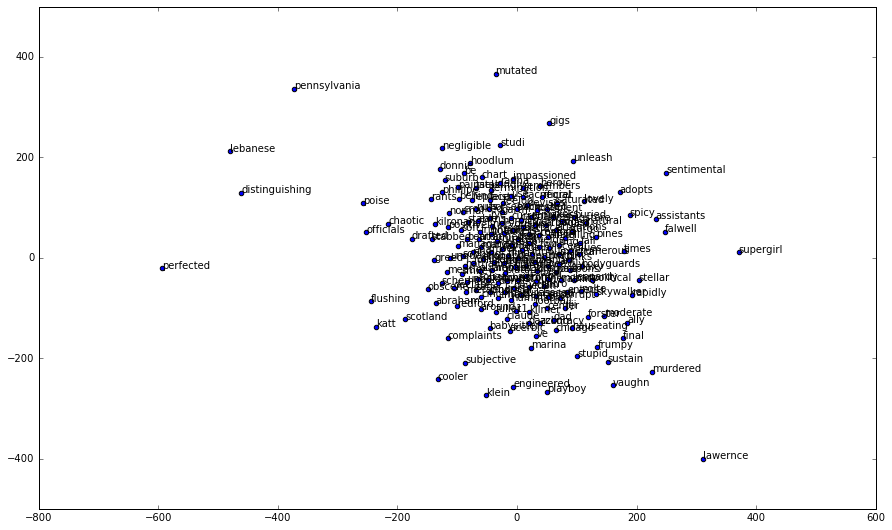

In [39]:
def plot_embeddings(w2v_model, target_terms):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        if target_term in w2v_model.vocab:
            term_vectors.append(w2v_model[target_term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_terms, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
movie_vocab = [k for (k, v) in movie_model.vocab.items()]
plot_embeddings(movie_model, movie_vocab[:200])

{'in', 'or', 'over', 'the', 'weren', 'only', 'mustn', 'be', 'more', 'some', 'most', 'can', 'theirs', 'hers', 'mightn', 'that', 'themselves', 're', 'any', 'with', 'against', 'what', 'there', 'isn', 'own', 'don', 'doesn', 'my', 've', 'very', 'were', 'i', 'it', 'other', 'our', 'while', 't', 'once', 'should', 'she', 'when', 'to', 'yourself', 'yours', 'does', 'than', 'same', 'out', 'doing', 'y', 'after', 'her', 'myself', 'because', 'those', 'ours', 'o', 'both', 'below', 'so', 'had', 'on', 'shan', 'd', 'this', 'has', 'he', 'they', 'until', 'having', 'further', 'is', 'no', 'are', 'll', 'haven', 'a', 'being', 's', 'which', 'and', 'again', 'too', 'hasn', 'm', 'into', 'was', 'himself', 'wouldn', 'off', 'ourselves', 'these', 'itself', 'then', 'from', 'why', 'before', 'now', 'your', 'between', 'each', 'at', 'nor', 'we', 'up', 'won', 'few', 'whom', 'if', 'who', 'his', 'will', 'have', 'such', 'all', 'as', 'me', 'yourselves', 'of', 'couldn', 'where', 'shouldn', 'ain', 'down', 'by', 'for', 'you', 'an'

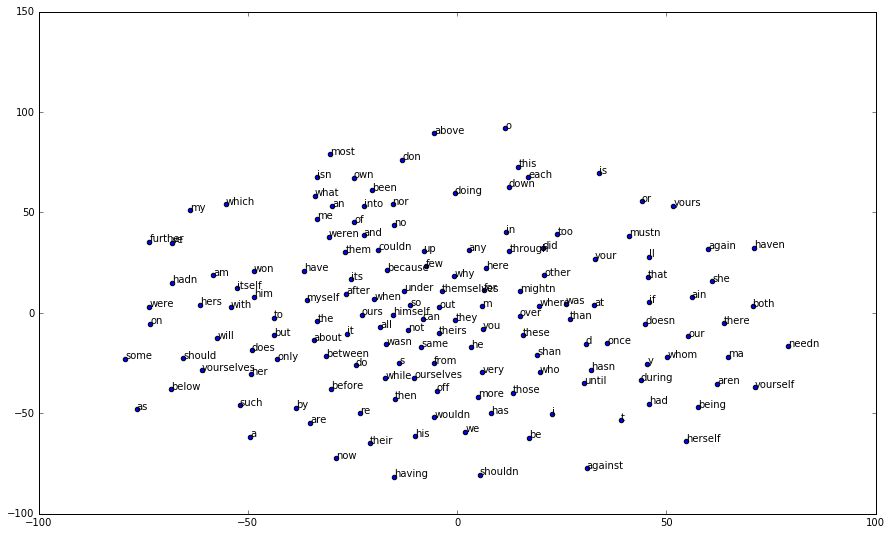

In [40]:
# here are some terms we can plot...
english_stop_words = set(nltk.corpus.stopwords.words('english'))
print(english_stop_words)
plot_terms = english_stop_words
plot_embeddings(movie_model, plot_terms)

# Now let's try to use these embeddings to do some classification.  NOTE : Taking the mean of embeddings vectors is an interesting idea, but often will not perform as well as bag of words or Doc2Vec.  We'll look at Doc2Vec later...

In [41]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v_model[w] for w in words if w in self.w2v_model]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

# This pipeline uses our Movie Reviews Word2Vec model
movie_lr_w2v = Pipeline([
    ("Movie Review word2vec vectorizer", MeanEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())])

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
X = [movie_reviews.words(fileid) for fileid in movie_reviews.fileids()]
# these are the categories
y_categories = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]
# this maps the strings to 1 -> positive 0 -> negative (anything else)
y = [1 if category == 'pos' else 0 for category in y_categories ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

In [44]:
movie_lr_w2v.fit(X_train,y_train)

Pipeline(steps=[('Movie Review word2vec vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x000001B5805571D0>), ('Logistic Regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [45]:
movie_cv_auc_scores = cross_val_score(movie_lr_w2v, X, y, cv = 5, scoring = 'roc_auc')
print(movie_cv_auc_scores)
print(np.mean(movie_cv_auc_scores))

[ 0.719425  0.75075   0.7179    0.7019    0.751825]
0.72836


# Now let's do something slightly different and set up a document-level Doc2Vec model and use this for classification (also using Gensim)

In [46]:
# PRO TIP : This is a generator class (notice the __iter__() and the yield)
# This makes setting up a "LabeledSentence" class much easier and it becomes almost essential when training large 
# models for either Word2Vec or Doc2Vec since some corpora are so large that we cannot keep them in memory while training
# the vector model.  Therefore, you can "iterate" through files or database rows and only keep batches of them 
# in memory at a time
class TaggedNltkSentence(object):
    def __init__(self, nltk_corpus):
        self.nltk_corpus = nltk_corpus
    def __iter__(self):
        sent_idx = 0
        for sent in self.nltk_corpus.sents():
            sent_idx += 1
            # NOTE : These tags are not actually used during training time, but they are used
            # to index and potentially query to find similar sentences/paragraphs/documents in GenSim
            yield LabeledSentence(words=sent, tags=['SENT_%s' % sent_idx])

In [47]:
%time movie_d2v_model = Doc2Vec(TaggedNltkSentence(movie_reviews), size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 1min 8s


In [48]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model

    def fit(self, X, y):
        return self

    def transform(self, X):
        # NOTE : infer_vector can take a list of strings (words) of arbitrary lenghth and infer a vector
        # given its model parameters
        return [self.d2v_model.infer_vector(doc) for doc in X]

In [49]:
# And this pipeline uses our Moview Review Doc2Vec model
movie_lr_d2v = Pipeline([
    ("Movie Review corpus doc2vec vectorizer", Doc2VecVectorizer(movie_d2v_model)),
    ("Logistic Regression", LogisticRegression())])

In [50]:
movie_lr_d2v.fit(X_train,y_train)

Pipeline(steps=[('Movie Review corpus doc2vec vectorizer', <__main__.Doc2VecVectorizer object at 0x000001B5FD001C18>), ('Logistic Regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [51]:
movie_d2v_cv_roc_scores = cross_val_score(movie_lr_d2v, X, y, cv = 5, scoring = 'roc_auc')
print(movie_d2v_cv_roc_scores)
print(np.mean(movie_d2v_cv_roc_scores))

[ 0.757675  0.77735   0.737825  0.763925  0.785325]
0.76442


# So why do we get much better results using a Doc2Vec model as opposed to the mean of the word vectors?
## Proposal : Word2Vec results in vectors which are constant for a word regardless of context
## Meanwhile, Doc2Vec method of infer_vector() uses the document/paragraph/sentence as context
## So while "great" always has the same vector, context and order matters for the document model

In [52]:
great_word_vector = movie_model['great']
print(great_word_vector)

[ 0.09751554 -0.42830959 -1.96941376 -1.04662943  0.54045159 -0.94396019
  0.71135789  0.06640786 -0.41094148 -1.09613287  1.51902878  1.05274165
  1.29429436  0.66765094  1.12889266 -0.44379869  0.44369012 -0.32848331
  0.75312483  0.93001121 -1.35288501  1.03812003 -0.46968344 -2.76447439
  1.35025549  0.5358687  -0.98938382  1.25510669  0.14097653 -0.6617837
 -0.65811396  0.04797867 -1.16525769  1.95607698 -0.1187093   0.69453365
  2.72492886  0.42175508  0.87164223  0.84938419  0.5282225  -0.53716415
 -1.13990533  1.02711773  0.34848991  0.42420179  0.09724361 -0.784136
 -1.3036077   0.13310097]


In [53]:
# In this example, the average embeddings vectors for sentence_1 and sentence_2 would be the same
# However, doc2vec sees them as different.  This will allow context to be handled differently and a classifier
# will be able to learn about these differences

sentence_1 = 'great movie to see'
sentence_2 = 'to see great movie'
sentence_3 = 'OK movie to view'

sentence_1_vec = movie_d2v_model.infer_vector(nltk.tokenize.word_tokenize(sentence_1))
sentence_2_vec = movie_d2v_model.infer_vector(nltk.tokenize.word_tokenize(sentence_2))
sentence_3_vec = movie_d2v_model.infer_vector(nltk.tokenize.word_tokenize(sentence_3))

print('1 compared to 2 : ' + str(sklearn.metrics.pairwise.cosine_similarity(sentence_1_vec, sentence_2_vec)))
print('2 compared to 3 : ' + str(sklearn.metrics.pairwise.cosine_similarity(sentence_2_vec, sentence_3_vec)))
print('1 compared to 3 : ' + str(sklearn.metrics.pairwise.cosine_similarity(sentence_1_vec, sentence_3_vec)))

1 compared to 2 : [[ 0.74319029]]
2 compared to 3 : [[ 0.4488467]]
1 compared to 3 : [[ 0.16532835]]


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\